In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, SpatialDropout1D
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers.core import Dense,Activation,Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence,text
from keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sample_df = pd.read_csv('../input/sample_submission.csv')

In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
train_df.shape

(19579, 3)

In [5]:
#check authors
train_df.author.unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [6]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [7]:
#check what is the maximum and the minimum length of text
print('max',len(train_df.text.max()))
print('min',len(train_df.text.min()))

('max', 97)
('min', 27)


In [8]:
#print the max and min length text
print('max',train_df.text.max())
print('min',train_df.text.min())

('max', 'you could not hope to conquer, and yet you gave me the pain of a triumph over my dearest friend."')
('min', '" Odenheimer, restaurateur.')


In [9]:
#convert the authors/labels into one hot encoded values
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(train_df.author.values)
y = np_utils.to_categorical(y)

In [10]:
#divide the data into train and validation 
x_train, x_valid, y_train, y_valid = train_test_split(train_df.text.values,
                                                      y,
                                                      stratify = y,
                                                     random_state = 2018,
                                                     test_size = 0.2)

In [11]:
#use Keras Tokenizer to tokenize the texts
token = text.Tokenizer(num_words = None)
max_len = 80

token.fit_on_texts(list(x_train) + list(x_valid))
xtrain_seq = token.texts_to_sequences(x_train)
xvalid_seq = token.texts_to_sequences(x_valid)

print(xtrain_seq[:1])
# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len,padding = 'post')
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len,padding = 'post')
print(xtrain_pad[:1])

[[11, 8, 1670, 4, 491, 1, 162, 154, 6, 4304, 2476, 57, 751, 99, 3509]]
[[  11    8 1670    4  491    1  162  154    6 4304 2476   57  751   99
  3509    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]


In [12]:
# load the GloVe vectors in a dictionary:
embeddings = {}
f = open('../../WordVectors/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

print('%s word vectors loaded.' % len(embeddings_index))

2196017it [01:11, 30853.32it/s]

Found 2196016 word vectors.


In [13]:
word_index = token.word_index

In [14]:
# create an embedding matrix for the words we have in our dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22564/22564 [00:00<00:00, 473833.95it/s]


In [15]:
#word_index = token.word_index
def create_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                        weights = [embedding_matrix],
                        trainable = True,
                         input_length=max_len))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3,return_sequences = True)))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3))
    model.add(Activation('softmax'))
    #adam = Adam(lr=0.01, decay = 0.01)
    sgd = SGD(lr=0.01,momentum=0.9,nesterov = True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd,
                 metrics=['accuracy'])
    return model

In [16]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()

In [17]:
def plot_loss():
    #plot training curve
    loss = history.losses
    val_loss = history.val_losses
    acc = history.acc
    val_acc = history.val_acc

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Acc - Loss Trend')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.plot(acc, 'black', label='Training Accuracy')
    plt.plot(val_acc, 'red', label='Validation Accuracy')
    plt.xticks(range(0,10)[0::2])
    plt.legend()
    plt.show()
    

In [18]:
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', epsilon=0.0001, min_lr=0.0000001)

model = create_model()
model.fit(xtrain_pad, y=y_train, batch_size=64, epochs=100, verbose=1, 
          validation_data=(xvalid_pad, y_valid), callbacks=[earlystop,history,reduceLR])

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 60s - loss: 1.0364 - acc: 0.4679 - val_loss: 0.9210 - val_acc: 0.5891
Epoch 2/100
15663/15663 [==============================] - 58s - loss: 0.9449 - acc: 0.5701 - val_loss: 0.8410 - val_acc: 0.6236
Epoch 3/100
15663/15663 [==============================] - 57s - loss: 0.8834 - acc: 0.6162 - val_loss: 0.7359 - val_acc: 0.7033
Epoch 4/100
15663/15663 [==============================] - 57s - loss: 0.8243 - acc: 0.6533 - val_loss: 0.7477 - val_acc: 0.7219
Epoch 5/100
15663/15663 [==============================] - 57s - loss: 0.7589 - acc: 0.6880 - val_loss: 0.6433 - val_acc: 0.7561
Epoch 6/100
15663/15663 [==============================] - 57s - loss: 0.7145 - acc: 0.7144 - val_loss: 0.5922 - val_acc: 0.7610
Epoch 7/100
15663/15663 [==============================] - 58s - loss: 0.6599 - acc: 0.7399 - val_loss: 0.6470 - val_acc: 0.7408
Epoch 8/100
15663/15663 [=======================

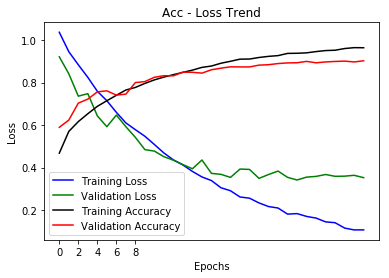

In [19]:
plot_loss()

In [20]:
#the same operations are also carried out on the test set
xtest_seq = token.texts_to_sequences(test_df.text)
xtest_pad = sequence.pad_sequences(xtest_seq,maxlen = max_len,padding = 'post')

In [21]:
# Now predict
prediction = model.predict(xtest_pad)

In [22]:
a2c = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
result = pd.read_csv('../input/sample_submission.csv')
for a, i in a2c.items():
    result[a] = prediction[:, i]
    
result.to_csv('../submit/lstmsubmission.csv',index = False)
result.head()

,id,EAP,HPL,MWS
0,id02310,0.000569,0.000413,0.999017
1,id24541,0.999985,0.000012,0.000003
2,id00134,0.000094,0.999831,0.000075
3,id27757,0.995035,0.004858,0.000107
4,id04081,0.894464,0.032369,0.073168


In [23]:
result.head(10)

,id,EAP,HPL,MWS
0,id02310,0.000569,0.000413,0.999017
1,id24541,0.999985,0.000012,0.000003
2,id00134,0.000094,0.999831,0.000075
3,id27757,0.995035,0.004858,0.000107
4,id04081,0.894464,0.032369,0.073168
5,id27337,0.886410,0.064986,0.048604
6,id24265,0.998065,0.001659,0.000276
7,id25917,0.105234,0.171933,0.722833
8,id04951,0.999959,0.000039,0.000002
9,id14549,0.998531,0.000901,0.000568
